# **Final Assigment: Yahoo Answers Topic**

# *** Part 3***

---

We house part 3 in separate notebooks. We have one notebook for part A and B, and one notebook for part C and D. This decision was ultimately made due to computational cost concerns. The organization and data pipeline could certainly be improved.

In this part AB notebook, we now try running our models on the expanded portions of the dataset. Our dataset is 1.46M documents, so we are quite limited in our computational power. We at most run our model on 25% of the dataset, and that alone took 3 hours.

we re-load needed libraries

In [1]:

# run if colab/kaggle
!pip install -U transformers

!pip install -U datasets fsspec # run this if you run with colab.

!pip install -U datasets evaluate

!pip install nltk
import nltk
nltk.download('stopwords')
!pip install wordcloud

!pip install lime

#!pip install -U scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e00947827ee94b6d6ada1078e904c200ce3348fac8ef1065f6bde8e49337e570
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
from datasets import Dataset
import evaluate
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

In [ ]:
# DO NOT RUN IN KAGGLE
#!pip uninstall scikit-learn -y
#!pip install scikit-learn==1.6.1



Below is where we input our hugging face token. This is how we exported models to our individual hugging face accounts.

I removed my token for this submission

In [5]:
from huggingface_hub import login
login(token="")

We put all of the df preprocessing and loading of the yahoo answers topic into one chunk so that we can run and load it in one go.

We load the train and test sets, input label mapping, conduct some exploratory review of the dataset to confirm its size, and remove empty questions/answers.

In [6]:
from datasets import load_dataset
import pandas as pd

# Load the dataset
train_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="train")
test_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="test")

# Convert to pandas DataFrame for easier handling
df = pd.concat([train_dataset.to_pandas(), test_dataset.to_pandas()]).reset_index(drop=True)
label_map = {'Society & Culture': 0, 'Science & Mathematics': 1, 'Health': 2, 'Education & Reference': 3,
             'Computers & Internet': 4, 'Sports': 5, 'Business & Finance': 6, 'Entertainment & Music': 7,
             'Family & Relationships': 8, 'Politics & Government': 9}


# Show basic info
print(f"Dataset size: {len(df)} documents")


# I imported a library that detects the language of the text.
!pip install langdetect
from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from collections import defaultdict
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import pandas as pd


from sklearn.manifold import TSNE
from collections import Counter
import re

from datasets import load_dataset, DatasetDict
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          EarlyStoppingCallback)
import evaluate, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import torch, random, os
from datasets import Dataset, DatasetDict

import string
from transformers import pipeline

empty_questions = df['question_content'].apply(lambda x: x.strip() == "")
empty_answers = df['best_answer'].apply(lambda x: x.strip() == "")

print("Empty questions:", empty_questions.sum())
print("Empty answers:", empty_answers.sum())

df = df[~empty_questions & ~empty_answers]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.20k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset size: 1460000 documents
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=2db1c98414d7ac1b74c5beb090e37c7851c9c29699bb1a35c8157f53b3102ea3
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
Empty questions: 658761
Empty answers: 25606


we verify that we have the dataset intact.

In [7]:
df.head()

,id,topic,question_title,question_content,best_answer
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,3,6,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,4,6,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


Now we load the model from part 2. We take the part 2 model, pre-trained on the small amount of data, as a starting point to proceed.

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load model directly
tokenizer = AutoTokenizer.from_pretrained("tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2")
model = AutoModelForSequenceClassification.from_pretrained("tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2")

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

# Part 3: State of the Art Comparison (2 points)

In this section, we shall benchmark our model against the SOA with the full dataset now available.

## a) Full Dataset Training (0.25 points):

Our goal here is to understand how the model performs as we keep adding more and more data to train the model. As mentioned above, it is unlikely that we will be able to use a majority of our dataset.

In order to preserve class balances as we cut the dataset, we will perform stratification to ensure that we maintain the class balances that we have in the data.

As we begin, we set some additional model parameters at the top.

In [9]:
df

,id,topic,question_title,question_content,best_answer
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,3,6,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,4,6,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...
...,...,...,...,...,...
1459991,59991,9,Why do the conservatives want us to stay and p...,Cant they see we will just keep losing troops....,George Bush illegally and unconstitutionally i...
1459992,59992,5,Who else thinks that ref(uru) should be reprim...,"Can you believe that guy???? Red card, red car...",What about the obvious handball? The ref shou...
1459994,59994,8,guys only pleez?,is their anyone out their 4 me who are 13to15 ...,omg i love that in a girrl\nim not looking for...
1459996,59996,7,Tell me something about life most people don't...,"Do you know anything about life, or words of w...",That there is a hell and everyone thinks their...


In [12]:
model_ckpt   = "bert-base-uncased"
num_labels   = 10
max_length   = 128 # truncate / pad length
batch_size   = 100
seed         = 42

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(seed)





tok = AutoTokenizer.from_pretrained(model_ckpt)


In [13]:
df_model = df[["question_title", "question_content", "topic"]].copy()
df_model["text"] = df_model["question_title"] + " " + df_model["question_content"]
df_model = df_model[["text", "topic"]].rename(columns={"topic": "label"})  # HF expects "label"

In [14]:
# Tokenization function
def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=max_length)

# Modular function for sampling/splitting/tokenizing
def stratified_tokenized_split(df_model, pct, seed=42):
    df_sample, _ = train_test_split(
        df_model,
        train_size=pct,
        stratify=df_model["label"],
        random_state=seed
    )

    train_df, test_df = train_test_split(
        df_sample,
        test_size=0.2,
        stratify=df_sample["label"],
        random_state=seed
    )

    train_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(tokenize, batched=True)
    test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True)).map(tokenize, batched=True)

    train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return train_ds, test_ds


In [33]:
train_ds, test_ds = stratified_tokenized_split(df_model, pct=0.05, seed=42)


Map:   0%|          | 0/31437 [00:00<?, ? examples/s]

Map:   0%|          | 0/7860 [00:00<?, ? examples/s]

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

# Define metrics
metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")
    return {"accuracy": acc["accuracy"], "precision": prec["precision"], "recall": rec["recall"]}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
    output_dir="./bert-yahoo-5percent",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,
    seed=seed,
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=2
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Finally, train!
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.363500,0.831210,0.751018,0.747502,0.748154
2,0.780200,0.787647,0.759288,0.755730,0.755914
3,0.667200,0.783890,0.760560,0.758870,0.756673
4,0.597000,0.793807,0.761069,0.756903,0.757116
5,0.552700,0.798156,0.762468,0.758637,0.758766


TrainOutput(global_step=790, training_loss=0.792120853858658, metrics={'train_runtime': 1061.2066, 'train_samples_per_second': 148.119, 'train_steps_per_second': 0.744, 'total_flos': 1.034002046681856e+16, 'train_loss': 0.792120853858658, 'epoch': 5.0})

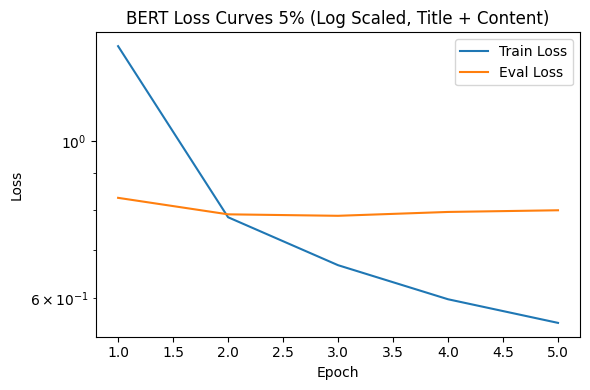

<Figure size 640x480 with 0 Axes>

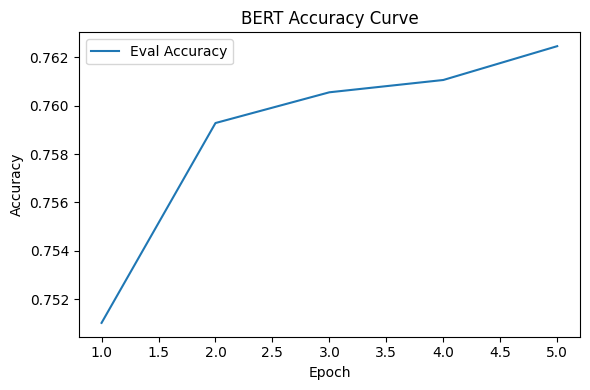

<Figure size 640x480 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt

# Extract log history
logs = trainer.state.log_history

# Containers
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

# Parse logs
for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e.get('eval_accuracy', None))  # Avoid KeyError
        steps_eval.append(e['epoch'])

# Plot loss curves
plt.figure(figsize=(6, 4))
plt.plot(steps_train, train_loss, label="Train Loss")
plt.plot(steps_eval, eval_loss, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.title("BERT Loss Curves 5% (Log Scaled, Title + Content)")
plt.tight_layout()
plt.show()
plt.savefig("Eval_Acc.png")

# Plot accuracy curve
if any(eval_acc):
    plt.figure(figsize=(6, 4))
    plt.plot(steps_eval, eval_acc, label="Eval Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("BERT Accuracy Curve")
    plt.tight_layout()
    plt.show()
    plt.savefig("Acc.png")


In [38]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Reload everything from your saved dir
#model = AutoModelForSequenceClassification.from_pretrained("./bert-yahoo-5percent/checkpoint-790")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
repo_name = "bert-yahoo-5percent"

# Push model
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/otausendschoen/bert-yahoo-5percent/commit/3191bfbeba07ae09d230da26901215097c0b7b04', commit_message='Upload tokenizer', commit_description='', oid='3191bfbeba07ae09d230da26901215097c0b7b04', pr_url=None, repo_url=RepoUrl('https://huggingface.co/otausendschoen/bert-yahoo-5percent', endpoint='https://huggingface.co', repo_type='model', repo_id='otausendschoen/bert-yahoo-5percent'), pr_revision=None, pr_num=None)

-------------

In [25]:
train_ds, test_ds = stratified_tokenized_split(df_model, pct=0.2, seed=42)


Map:   0%|          | 0/125750 [00:00<?, ? examples/s]

Map:   0%|          | 0/31438 [00:00<?, ? examples/s]

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
    output_dir="./bert-yahoo-20percent",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,
    seed=seed,
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=2
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Finally, train!
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.729500,0.705427,0.776990,0.775149,0.772693
2,0.618700,0.701333,0.780139,0.778771,0.775480
3,0.537400,0.723720,0.777658,0.773095,0.774796
4,0.475800,0.733567,0.777530,0.773755,0.774024
5,0.431900,0.748520,0.776513,0.772678,0.773201


TrainOutput(global_step=3145, training_loss=0.5586597048421353, metrics={'train_runtime': 3676.5704, 'train_samples_per_second': 171.015, 'train_steps_per_second': 0.855, 'total_flos': 4.136073969216e+16, 'train_loss': 0.5586597048421353, 'epoch': 5.0})

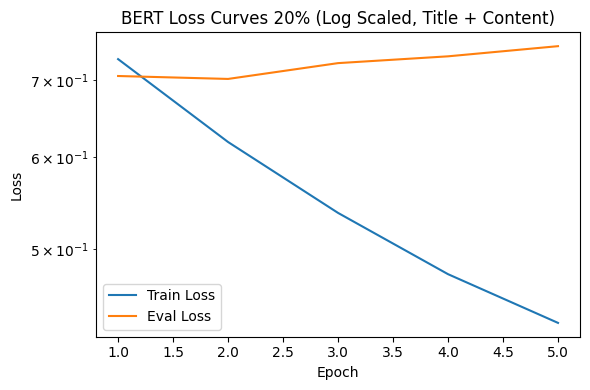

<Figure size 640x480 with 0 Axes>

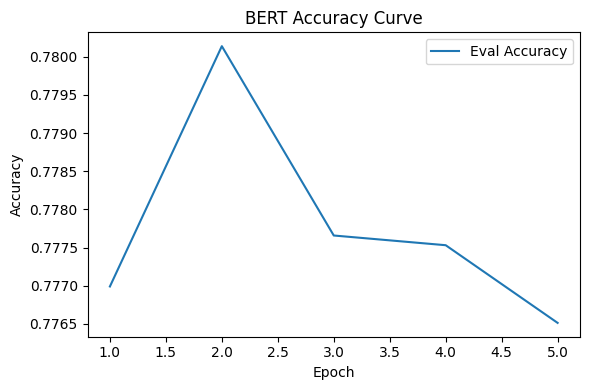

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt

# Extract log history
logs = trainer.state.log_history

# Containers
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

# Parse logs
for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e.get('eval_accuracy', None))  # Avoid KeyError
        steps_eval.append(e['epoch'])

# Plot loss curves
plt.figure(figsize=(6, 4))
plt.plot(steps_train, train_loss, label="Train Loss")
plt.plot(steps_eval, eval_loss, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.title("BERT Loss Curves 20% (Log Scaled, Title + Content)")
plt.tight_layout()
plt.show()
plt.savefig("Eval_Acc.png")

# Plot accuracy curve
if any(eval_acc):
    plt.figure(figsize=(6, 4))
    plt.plot(steps_eval, eval_acc, label="Eval Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("BERT Accuracy Curve")
    plt.tight_layout()
    plt.show()
    plt.savefig("Acc.png")


-------------------

In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Reload everything from your saved dir
#model = AutoModelForSequenceClassification.from_pretrained("./bert-yahoo-20percent/checkpoint-790")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
repo_name = "bert-yahoo-20percent"

# Push model
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/otausendschoen/bert-yahoo-20percent/commit/f9a0b2d3c047fd8c11c8aa40f91bba6fcf36b19a', commit_message='Upload tokenizer', commit_description='', oid='f9a0b2d3c047fd8c11c8aa40f91bba6fcf36b19a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/otausendschoen/bert-yahoo-20percent', endpoint='https://huggingface.co', repo_type='model', repo_id='otausendschoen/bert-yahoo-20percent'), pr_revision=None, pr_num=None)

------------